In [1]:
import pycewise
import pandas
import numpy

print(pycewise.__version__)
print(pycewise.__git_version__)

0.1.2
27f261d5aada4d0bce84394bfe29d3cd3bc89d46


The data used in this notebook has been generated by [this notebook](https://github.com/Ezibenroc/calibration_analysis/blob/17e67527b6b4dd0fd5b41754eec106f59a821ce5/dahu/mpi/pycewise_demo.ipynb) using [these archives](https://github.com/Ezibenroc/calibration_analysis/tree/17e67527b6b4dd0fd5b41754eec106f59a821ce5/dahu/mpi/pycewise_demo/1).

In [2]:
def compute_df_pred(df_data, mode):
    numpy.random.seed(42)
    df = pandas.DataFrame({'x':10**numpy.random.uniform(1, 9, 1000), 'mode':mode})
    if mode == 'datadog':
        reg = piecewise(df_data['x'], df_data['y'])
        df['y'] = df.apply(lambda row: reg.predict(row['x']), axis=1)
        breaks = [seg.end_t for seg in reg.segments[:-1]]
    else:
        reg = pycewise.compute_regression(df_data['x'], df_data['y'], mode=mode).auto_simplify()
        df['y'] = df.apply(lambda row: reg.predict(row['x']), axis=1)
        breaks = reg.breakpoints
    df['segment'] = 0
    for i, bp in enumerate(breaks):
        df.loc[df['x'] > bp, 'segment'] = i+1
    return df

In [3]:
f='../data/prediction/modeling/network/pycewise/pycewise_data.csv'
data = pandas.read_csv(f)
data = data[data['experiment'] != 'isend']
data['x'] = data['msg_size']
data['y'] = data['duration']
all_pred = []
for cluster in data['cluster'].unique():
    for exp in data['experiment'].unique():
        pred = compute_df_pred(data[(data['cluster'] == cluster) & (data['experiment'] == exp)], mode='log')
        pred['experiment'] = exp
        pred['cluster'] = cluster
        all_pred.append(pred)
predictions = pandas.concat(all_pred)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R -i data

library(dplyr)
library(ggplot2)
library(Cubist)

str(data)

R[write to console]: 
Attachement du package : ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Le chargement a nécessité le package : lattice



'data.frame':	2400 obs. of  6 variables:
 $ experiment: chr  "pingpong" "pingpong" "pingpong" "pingpong" ...
 $ cluster   : chr  "dahu" "dahu" "dahu" "dahu" ...
 $ msg_size  : int  3 6 8 11 27 34 35 39 43 50 ...
 $ duration  : num  2.65e-06 3.09e-06 2.69e-06 3.09e-06 3.41e-06 ...
 $ x         : int  3 6 8 11 27 34 35 39 43 50 ...
 $ y         : num  2.65e-06 3.09e-06 2.69e-06 3.09e-06 3.41e-06 ...


In [6]:
%%R -i predictions

str(predictions)

'data.frame':	12000 obs. of  6 variables:
 $ x         : num  9.92e+03 4.03e+08 7.18e+06 6.16e+05 1.77e+02 ...
 $ mode      : chr  "log" "log" "log" "log" ...
 $ y         : num  8.39e-06 6.59e-02 1.20e-03 1.32e-04 3.35e-06 ...
 $ segment   : int  0 1 1 1 0 0 0 1 1 1 ...
 $ experiment: chr  "pingpong" "pingpong" "pingpong" "pingpong" ...
 $ cluster   : chr  "dahu" "dahu" "dahu" "dahu" ...


`summarise()` regrouping output by 'cluster' (override with `.groups` argument)
`summarise()` regrouping output by 'cluster', 'experiment' (override with `.groups` argument)


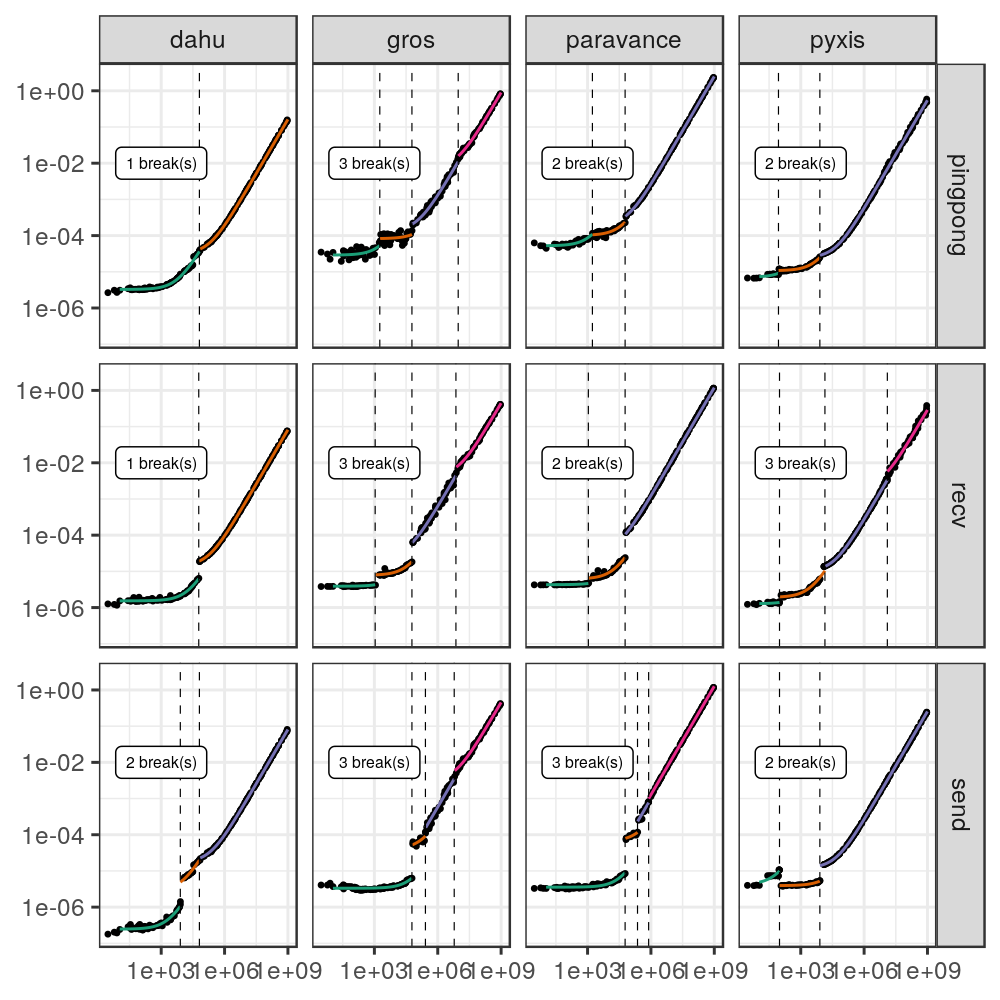

In [7]:
%%R -w 5 -h 5 --units in -r 200

nb_breaks = predictions %>%
    group_by(cluster, experiment) %>%
    summarise(nb=paste(max(segment), "break(s)")) %>%
    mutate(x=1e3, y=1e-2) %>%
    ungroup()

breaks = predictions %>%
    group_by(cluster, experiment, segment) %>%
    summarise(breaks=max(x)) %>%
    group_by(cluster, experiment) %>%
    filter(breaks < max(breaks))

plot = ggplot() +
    aes(x=x, y=y) +
    geom_point(data=data, size=0.5) +
    geom_line(data=predictions %>% arrange(x), aes(group=segment, color=factor(segment %% 4))) +
    geom_vline(data=breaks, aes(xintercept=breaks), linetype="dashed", size=0.2) +
    geom_label(data=nb_breaks, aes(label=nb), color="black", size=2) +
    facet_grid(experiment~cluster) +
    scale_x_log10() +
    scale_y_log10() +
    theme_bw() +
    scale_color_brewer(palette="Dark2") +
    theme(legend.position='none') +
    theme(axis.title.x=element_blank(), axis.title.y=element_blank())
ggsave(filename='../img/prediction/modeling/network/pycewise_demo.pdf', plot=plot, width=7, height=5)
plot